In [469]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
import numpy as np
import itertools
import copy
import matplotlib.pyplot as plt
import random
import json
from dataraw_sampling import *
import itertools
import operator as op
from functools import reduce
from itertools import chain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_attributes=4; num_attr_vals=3; num_cards_per_query=3; nest_depth_int=2

N_train = (num_attr_vals**num_attributes)**num_cards_per_query
N_val = N_train

data = gen_full_dataset(num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int)
filename = '../Raw_Datasets/SET/{}Attr-{}Vals-{}CardsPerQ-{}NestDepth-Full-{}Train-{}Val.json'.format(num_attributes, num_attr_vals, nest_depth_int, N_train, N_val)

# with open(filename, 'w') as f:
#     json.dump(data, f)

/app/Contrastive-Learning-Benchmarking/SecondPass-CardGame-experiments/dataraw_sampling.py:96: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if part == '(':
/app/Contrastive-Learning-Benchmarking/SecondPass-CardGame-experiments/dataraw_sampling.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif part == ')':


num_attributes 4
num_attr_vals 3
num_cards_per_query 3
nest_depth_int 2
key_support_size 81
query_support_size 531441
max_len_q 17
len_k 4
hold_out False
sparsity_estimate 0.012345679012345678
vocab_size 20
( 12
) 13
NULL 14
SEP 15
SOS 16
EOS 17
PAD 18
PLH 19


IndexError: Replacement index 5 out of range for positional args tuple

## Eval Query Code

In [478]:
def eval_cardpair_by_idx(num_attributes, num_attr_vals, querycard1_idx, querycard2_idx):
    qc1_properties = decode_key_idx(num_attributes, num_attr_vals, querycard1_idx)
    qc2_properties = decode_key_idx(num_attributes, num_attr_vals, querycard2_idx)
#     print(qc1_properties, ' | ', qc2_properties)
    key_properties = SET_resolve_fn(qc1_properties, qc2_properties)
    key_idx = encode_key_idx(num_attributes, num_attr_vals, key_properties)
    return key_idx, key_properties

num_attributes=4; num_attr_vals=3;
querycard1_idx = 10
querycard2_idx = 11
eval_cardpair_by_idx(num_attributes, num_attr_vals, querycard1_idx, querycard2_idx)

(9, array([0, 1, 0, 0]))

In [456]:
def SET_cardpair_resolve_fn(card1, card2):
    '''
    card1, card2: property lists or ndarrays.
    '''
    assert card1.shape == card2.shape
    return np.array([SET_derive_property(card1[i], card2[i]) for i in range(len(card1))])

def check_part_type_for_resolve_fn(num_attributes, num_attr_vals, part):
    if isinstance(part, np.ndarray):
        assert part.shape[0] == num_attributes
        return [part]
    elif isinstance(part, list):
        assert part[0] == 'OR'
        return part[1:] # remove OR
    else:
        breakpoint()
        raise ValueError('check query part input type.')
    
def resolve_fn(num_attributes, num_attr_vals, query_part1, query_part2):
    '''
    part1, part2: either property list/ndarray e.g. array([0, 0, 0, 0]), 
                  or list in format ['OR', array([0, 0, 0, 0]), array([0, 0, 0, 0]), ...]
    '''
    if isinstance(query_part1, np.ndarray) and isinstance(query_part2, np.ndarray):
        key_properties = SET_cardpair_resolve_fn(query_part1, query_part2)
        return key_properties # nd.array
    else: 
        query_part1 = check_part_type_for_resolve_fn(num_attributes, num_attr_vals, query_part1)
        query_part2 = check_part_type_for_resolve_fn(num_attributes, num_attr_vals, query_part2)
        cardpairs = itertools.product(query_part1, query_part2)
        key_list = ['OR']
        for card1, card2 in cardpairs:
            if isinstance(card1, str) or isinstance(card2, str):
                breakpoint()
            key_list.append(SET_cardpair_resolve_fn(card1, card2))
        return key_list # list

In [562]:
def evaluate_nested_query_parts(num_attributes, num_attr_vals, nested_query_parts):
    '''
    query_parts: a list of lists. 
    e.g. ['AND', array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0])]
    e.g. ['AND', ['OR', array([0, 0, 0, 0]), array([0, 0, 0, 0])], ['AND', array([0, 0, 0, 0]), array([0, 0, 0, 0])], array([0, 0, 0, 0])]
    '''
    operator = nested_query_parts[0]
    assert operator in ('OR', 'AND')
    if operator == 'OR':
        ans = nested_query_parts
    else:
        stack = []
        nested_query_stack = nested_query_parts[1:][::-1]  # remove AND, reverse
        while nested_query_stack:
            part = nested_query_stack.pop()
            if isinstance(part, list):
                part = evaluate_nested_query_parts(num_attributes, num_attr_vals, part)
            if stack:
                last_part = stack.pop()
                res = resolve_fn(num_attributes, num_attr_vals, last_part, part)
            else:
                res = part
            stack.append(res)
        assert len(stack) == 1
        ans = stack.pop()
    return ans

def test_evaluate_nested_query_parts():
    num_attributes=4; num_attr_vals=3;
    nest_query_parts1 = ['AND', np.array([0, 1, 0, 0]), np.array([2, 0, 0, 2]), np.array([0, 0, 1, 0])]
    assert (evaluate_nested_query_parts(num_attributes, num_attr_vals, nest_query_parts1) == np.array([2, 1, 2, 2])).all()
    nest_query_parts2 = [
        'AND', 
        ['OR', np.array([1,0,1,1]), np.array([2,1,1,0])], 
        np.array([2,1,1,0]), np.array([1,0,1,0]), np.array([0,0,0,0]), 
        ['AND', np.array([2,0,2,2]), np.array([1,1,1,1])], 
        np.array([1,0,0,2]), np.array([2,2,1,1]), 
        ['OR', np.array([2,2,1,2]), np.array([1,1,1,2])], np.array([1,0,2,2])
    ]
    print(evaluate_nested_query_parts(num_attributes, num_attr_vals, nest_query_parts2))
    # ['OR', array([2, 2, 2, 2]), array([1, 1, 2, 2]), array([0, 0, 2, 1]), array([2, 2, 2, 1])]
    
test_evaluate_nested_query_parts()

['OR', array([2, 2, 2, 2]), array([1, 1, 2, 2]), array([0, 0, 2, 1]), array([2, 2, 2, 1])]


In [ ]:
['AND',
 ['AND',
  ['AND', 27, 40],
  ['AND', ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28], ['AND', 59, 13]]],
 ['AND', ['AND', ['DERIVE'], 47], ['AND', 53, ['AND', 21, 9]]]]

## Sample a query

In [ ]:
# need to explain syntax and operators of the problem

In [61]:
np.random.choice(4, size=2)

array([0, 1])

In [40]:
num_attributes=4; num_attr_vals=3;
num_AND = 10
num_OR = 3
nest_depth = 2

In [452]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

In [453]:
def derive_shatter_bucket_probs(num_attributes, num_attr_vals):
    # (81 choose 1)*1, (81 choose 2)*2, .... (81 choose 81)*81
    num_datapoints_by_bucket = np.array([ncr(num_attr_vals ** num_attributes, subset_size) for subset_size in range(1, num_cards+1)])
    bucket_probs = num_datapoints_by_bucket / np.sum(num_datapoints_by_bucket)
    return bucket_probs.astype(float)

def sample_shattering_bucket(num_attributes, num_attr_vals, bucket_probs):
    sampled_bucket = np.random.choice(a=num_attr_vals ** num_attributes, p=bucket_probs)
    return sampled_bucket

def sample_subset_in_bucket(num_attributes, num_attr_vals, sampled_bucket):
    sampled_bucket_cards = np.random.choice(
        a=num_attr_vals ** num_attributes, size=sampled_bucket, replace=False)
    return sampled_bucket_cards

def sample_subset(num_attributes, num_attr_vals, bucket_probs):
    sampled_bucket = sample_shattering_bucket(num_attributes, num_attr_vals, bucket_probs)
    sampled_bucket_cards = sample_subset_in_bucket(num_attributes, num_attr_vals, sampled_bucket)
    return sampled_bucket_cards, sampled_bucket

In [454]:
def sample_OR_slot(num_cards, sampled_subset, i, derive_pos):
    if i == derive_pos:
        return ['DERIVE']
    else:
        cards_in_OR_slot = list(np.random.choice(a=num_cards, size=len(sampled_subset), replace=False))
        return ['OR'] + cards_in_OR_slot

In [530]:
def construct_query_from_subset(num_attributes, num_attr_vals, num_EVAL, num_OR, nest_depth, sampled_subset):
    assert num_OR <= num_EVAL
    num_cards = num_attr_vals ** num_attributes
    
    # (num_EVAL,)
    initial_card_indices = np.random.choice(a=num_cards, size=num_EVAL) 
    # (num_OR,)
    OR_positions = np.random.choice(a=num_EVAL, size=num_OR, replace=False)
    # int
    OR_position_to_be_derived_from_rules = np.random.choice(a=OR_positions)
    
    # fill in the OR slots
    flat_card_indices = [
        sample_OR_slot(num_cards, sampled_subset, i, OR_position_to_be_derived_from_rules) if i in OR_positions else cidx \
        for i, cidx in enumerate(initial_card_indices)
    ]
    
    # nest the query
    for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = \
        nest_flat_query_parts(flat_parts=flat_card_indices, depth=0, max_depth=nest_depth)
    
    # given the answer, fill up the ['DERIVE'] slot 
    
    
    
    return flat_card_indices
    # nest it and apply ['AND'], ['OR']?
    
    
    
    # derive the ? OR slot
    
    
num_EVAL = 10; num_OR=2; nest_depth=1
bucket_probs = derive_shatter_bucket_probs(num_attributes, num_attr_vals)
sampled_subset, key_size = sample_subset(num_attributes, num_attr_vals, bucket_probs)
flat_query_parts = construct_query_from_subset(num_attributes, num_attr_vals, num_EVAL, num_OR, nest_depth, sampled_subset)

<ipython-input-527-d409b8da1032>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['DERIVE'] in flat_parts:
<ipython-input-527-d409b8da1032>:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  pos_part_to_be_derived_stack = [flat_parts.index(['DERIVE'])+1]


In [531]:
flat_query_parts

[1,
 53,
 ['DERIVE'],
 54,
 ['OR',
  33,
  68,
  52,
  21,
  5,
  46,
  48,
  6,
  58,
  80,
  66,
  57,
  30,
  43,
  17,
  27,
  29,
  74,
  70,
  54,
  61,
  35,
  14,
  39,
  69,
  2,
  60,
  37,
  23,
  38,
  32,
  56,
  22,
  50,
  7,
  49,
  77,
  44,
  65,
  28],
 19,
 68,
 20,
 55,
 51]

In [557]:
weave = lambda values, sym: list(chain.from_iterable(zip(values, [sym] * len(values))))[:-1]

def nest_flat_query_parts(flat_parts, depth, max_depth):
    depth += 1 # TODO dont if len is 1

    if flat_parts == [['DERIVE']]:
        depth -= 1 
        for_eval = flat_parts[0]
        for_input = flat_parts[0]
        has_part_to_be_derived = True
        pos_part_to_be_derived_stack = []
        
    elif len(flat_parts) == 1:
        depth -= 1
        if isinstance(flat_parts[0], list):
            assert flat_parts[0][0] == 'OR'
            for_input = ['('] + weave([str(p) for p in flat_parts[0][1:]], '|') + [')']
        else:
            for_input = flat_parts[0]
        for_eval = flat_parts[0]
        has_part_to_be_derived = False
        pos_part_to_be_derived_stack = []
        
    elif len(flat_parts) == 2 or depth == max_depth:
        for_eval = ['AND'] + flat_parts
        for_input = ['(']
        for part in flat_parts:
            if isinstance(part, list) and part[0] == 'OR':
                or_part = ['('] + weave([str(p) for p in part[1:]], '|') + [')']
                for_input = for_input + or_part + ['&']
            else:
                for_input = for_input + [part] + ['&']
        for_input[-1] = ')'
        
        if ['DERIVE'] in flat_parts:
            has_part_to_be_derived = True
            pos_part_to_be_derived_stack = [flat_parts.index(['DERIVE'])+1]
        else:
            has_part_to_be_derived = False
            pos_part_to_be_derived_stack = []
        
    else:
        mid_idx = len(flat_parts) // 2
        
        L_e, L_i, _, L_has_part_to_be_derived, L_pos_part_to_be_derived = \
            nest_flat_query_parts(flat_parts[:mid_idx], depth, max_depth)
        R_e, R_i, depth, R_has_part_to_be_derived, R_pos_part_to_be_derived = \
            nest_flat_query_parts(flat_parts[mid_idx:], depth, max_depth)

        for_eval = ['AND', L_e, R_e]
        for_input = (
            ['('] + (L_i if isinstance(L_i, list) else [L_i]) + ['&'] + (R_i if isinstance(R_i, list) else [R_i]) + [')']
            
        )
        has_part_to_be_derived = L_has_part_to_be_derived or R_has_part_to_be_derived

        if has_part_to_be_derived:
            assert not (L_has_part_to_be_derived and R_has_part_to_be_derived)
            if L_has_part_to_be_derived:
                if L_pos_part_to_be_derived == []: assert L_e == ['DERIVE']
                L_pos_part_to_be_derived.append(1)
                pos_part_to_be_derived_stack = L_pos_part_to_be_derived
            else:
                if R_pos_part_to_be_derived == []: assert R_e == ['DERIVE']
                R_pos_part_to_be_derived.append(2)
                pos_part_to_be_derived_stack = R_pos_part_to_be_derived
        else:
            pos_part_to_be_derived_stack = []
    
    return for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack

In [558]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_query_parts, depth=0, max_depth=1)
print(''.join([str(i) for i in  for_input]))

(1&53&['DERIVE']&54&(33|68|52|21|5|46|48|6|58|80|66|57|30|43|17|27|29|74|70|54|61|35|14|39|69|2|60|37|23|38|32|56|22|50|7|49|77|44|65|28)&19&68&20&55&51)


<ipython-input-557-9c1a6b188691>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['DERIVE'] in flat_parts:
<ipython-input-557-9c1a6b188691>:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  pos_part_to_be_derived_stack = [flat_parts.index(['DERIVE'])+1]


In [555]:
flat_query_parts

[1,
 53,
 ['DERIVE'],
 54,
 ['OR',
  33,
  68,
  52,
  21,
  5,
  46,
  48,
  6,
  58,
  80,
  66,
  57,
  30,
  43,
  17,
  27,
  29,
  74,
  70,
  54,
  61,
  35,
  14,
  39,
  69,
  2,
  60,
  37,
  23,
  38,
  32,
  56,
  22,
  50,
  7,
  49,
  77,
  44,
  65,
  28],
 19,
 68,
 20,
 55,
 51]

In [534]:
for_eval

['AND',
 1,
 53,
 ['DERIVE'],
 54,
 ['OR',
  33,
  68,
  52,
  21,
  5,
  46,
  48,
  6,
  58,
  80,
  66,
  57,
  30,
  43,
  17,
  27,
  29,
  74,
  70,
  54,
  61,
  35,
  14,
  39,
  69,
  2,
  60,
  37,
  23,
  38,
  32,
  56,
  22,
  50,
  7,
  49,
  77,
  44,
  65,
  28],
 19,
 68,
 20,
 55,
 51]

In [561]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_query_parts, depth=0, max_depth=2)
print(''.join([str(i) for i in  for_input]))

((1&53&['DERIVE']&54&(33|68|52|21|5|46|48|6|58|80|66|57|30|43|17|27|29|74|70|54|61|35|14|39|69|2|60|37|23|38|32|56|22|50|7|49|77|44|65|28))&(19&68&20&55&51))


<ipython-input-557-9c1a6b188691>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['DERIVE'] in flat_parts:
<ipython-input-557-9c1a6b188691>:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  pos_part_to_be_derived_stack = [flat_parts.index(['DERIVE'])+1]


In [537]:
for_eval

['AND',
 ['AND',
  1,
  53,
  ['DERIVE'],
  54,
  ['OR',
   33,
   68,
   52,
   21,
   5,
   46,
   48,
   6,
   58,
   80,
   66,
   57,
   30,
   43,
   17,
   27,
   29,
   74,
   70,
   54,
   61,
   35,
   14,
   39,
   69,
   2,
   60,
   37,
   23,
   38,
   32,
   56,
   22,
   50,
   7,
   49,
   77,
   44,
   65,
   28]],
 ['AND', 19, 68, 20, 55, 51]]

In [559]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_query_parts, depth=0, max_depth=3)
print(''.join([str(i) for i in  for_input]))

(((1&53)&(['DERIVE']&54&(33|68|52|21|5|46|48|6|58|80|66|57|30|43|17|27|29|74|70|54|61|35|14|39|69|2|60|37|23|38|32|56|22|50|7|49|77|44|65|28)))&((19&68)&(20&55&51)))


<ipython-input-557-9c1a6b188691>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['DERIVE'] in flat_parts:


In [539]:
for_eval

['AND',
 ['AND',
  ['AND', 1, 53],
  ['AND',
   ['DERIVE'],
   54,
   ['OR',
    33,
    68,
    52,
    21,
    5,
    46,
    48,
    6,
    58,
    80,
    66,
    57,
    30,
    43,
    17,
    27,
    29,
    74,
    70,
    54,
    61,
    35,
    14,
    39,
    69,
    2,
    60,
    37,
    23,
    38,
    32,
    56,
    22,
    50,
    7,
    49,
    77,
    44,
    65,
    28]]],
 ['AND', ['AND', 19, 68], ['AND', 20, 55, 51]]]

In [560]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_query_parts, depth=0, max_depth=4)
print(''.join([str(i) for i in  for_input]))

(((1&53)&(DERIVE&(54&(33|68|52|21|5|46|48|6|58|80|66|57|30|43|17|27|29|74|70|54|61|35|14|39|69|2|60|37|23|38|32|56|22|50|7|49|77|44|65|28))))&((19&68)&(20&(55&51))))


<ipython-input-557-9c1a6b188691>:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['DERIVE'] in flat_parts:
<ipython-input-557-9c1a6b188691>:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if flat_parts == [['DERIVE']]:


In [552]:
for_input

['(',
 '(',
 '(',
 1,
 '&',
 53,
 ')',
 '&',
 '(',
 'DERIVE',
 '&',
 '(',
 54,
 '&',
 '(',
 '33',
 '|',
 '68',
 '|',
 '52',
 '|',
 '21',
 '|',
 '5',
 '|',
 '46',
 '|',
 '48',
 '|',
 '6',
 '|',
 '58',
 '|',
 '80',
 '|',
 '66',
 '|',
 '57',
 '|',
 '30',
 '|',
 '43',
 '|',
 '17',
 '|',
 '27',
 '|',
 '29',
 '|',
 '74',
 '|',
 '70',
 '|',
 '54',
 '|',
 '61',
 '|',
 '35',
 '|',
 '14',
 '|',
 '39',
 '|',
 '69',
 '|',
 '2',
 '|',
 '60',
 '|',
 '37',
 '|',
 '23',
 '|',
 '38',
 '|',
 '32',
 '|',
 '56',
 '|',
 '22',
 '|',
 '50',
 '|',
 '7',
 '|',
 '49',
 '|',
 '77',
 '|',
 '44',
 '|',
 '65',
 '|',
 '28',
 ')',
 ')',
 ')',
 ')',
 '&',
 '(',
 '(',
 19,
 '&',
 68,
 ')',
 '&',
 '(',
 20,
 '&',
 '(',
 55,
 '&',
 51,
 ')',
 ')',
 ')',
 ')']

In [551]:
for_eval

['AND',
 ['AND',
  ['AND', 1, 53],
  ['AND',
   ['DERIVE'],
   ['AND',
    54,
    ['OR',
     33,
     68,
     52,
     21,
     5,
     46,
     48,
     6,
     58,
     80,
     66,
     57,
     30,
     43,
     17,
     27,
     29,
     74,
     70,
     54,
     61,
     35,
     14,
     39,
     69,
     2,
     60,
     37,
     23,
     38,
     32,
     56,
     22,
     50,
     7,
     49,
     77,
     44,
     65,
     28]]]],
 ['AND', ['AND', 19, 68], ['AND', 20, ['AND', 55, 51]]]]

In [545]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_parts, depth=0, max_depth=10)
print(''.join([str(i) for i in  for_input]))

(DERIVE&(10&11))


In [513]:
pos_part_to_be_derived_stack

[1, 1, 2]

In [528]:
flat_parts = [['DERIVE'], 10, 11]
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived_stack = nest_flat_query_parts(flat_parts, depth=0, max_depth=10)
print(''.join([str(i) for i in  for_input]))

(DERIVE&(10,11))


In [457]:
# NOW: given ans subset, how to get derive_or 

def derive_missing_query_part(num_attributes, num_attr_vals, eval_expression, pos_part_to_be_derived_stack, key_part):
    '''
    eval_expression: with ['DERIVE']
    '''
    rhs = key_part.copy()
    
    operator = eval_expression[0]
    assert operator in ('OR', 'AND', 'DERIVE')
    
    if operator == 'DERIVE':
        return rhs
    
    elif operator == 'OR':
        return eval_expression
        
    else:

        derive_pos = pos_part_to_be_derived_stack.pop()
        
        # identify the part which has <derive>
        derive_part = derive_pos
        left_parts = eval_expression[:derive_pos]
        right_parts = eval_expression[derive_pos+1:]
        
        if right_parts:
            # np.array
            rhs = evaluate_nested_query_parts(num_attributes, num_attr_vals, ['AND'] + [rhs] + right_parts[::-1])
            if isinstance(rhs, np.ndarray): rhs.shape[0] == num_attributes 
            
        if left_parts:
            # np.array
            try:
                left_parts_simplified = evaluate_nested_query_parts(num_attributes, num_attr_vals, left_parts)
            except:
                import pdb; pdb.set_trace()
            
            if isinstance(lhs, np.ndarray): lhs.shape[0] == num_attributes 
            rhs = evaluate_nested_query_parts(num_attributes, num_attr_vals, ['AND'] + [rhs] + left_parts_simplified)
        
        return derive_missing_query_part(
            num_attributes, num_attr_vals,
            eval_expression=eval_expression[derive_pos], 
            pos_part_to_be_derived_stack=pos_part_to_be_derived_stack,
            key_part=rhs)
        

derive_missing_query_part(num_attributes, num_attr_vals, for_eval, pos_part_to_be_derived_stack.copy(), key_part=np.array([1,0,0,1]))

> <ipython-input-456-bbee5a921199>(17)check_part_type_for_resolve_fn()
     15     else:
     16         breakpoint()
---> 17         raise ValueError('check query part input type.')
     18 
     19 def resolve_fn(num_attributes, num_attr_vals, query_part1, query_part2):

ipdb> part
27
ipdb> eval_expression
*** NameError: name 'eval_expression' is not defined
ipdb> q
> <ipython-input-457-f1c44e1c74c9>(42)derive_missing_query_part()
     40                 import pdb; pdb.set_trace()
     41 
---> 42             if isinstance(lhs, np.ndarray): lhs.shape[0] == num_attributes
     43             rhs = evaluate_nested_query_parts(num_attributes, num_attr_vals, ['AND'] + [rhs] + left_parts_simplified)
     44 

ipdb> u
> <ipython-input-457-f1c44e1c74c9>(52)<module>()
     48             pos_part_to_be_derived_stack=pos_part_to_be_derived_stack,
     49             key_part=rhs)
     50 
     51 
---> 52 derive_missing_query_part(num_attributes, num_attr_vals, for_eval, pos_part_to_be_deriv

BdbQuit: 

In [487]:
def construct_cardpair_answer_lookup(num_attributes, num_attr_vals):
    num_cards = num_attr_vals**num_attributes
    lookup = {}
    for card1, card2 in itertools.combinations(list(range(num_cards)), 2):
        card1_properties = decode_key_idx(num_attributes, num_attr_vals, card1)
        card2_properties = decode_key_idx(num_attributes, num_attr_vals, card2)
        card3, card3_properties = eval_cardpair_by_idx(num_attributes, num_attr_vals, card1, card2)
#         print (card1_properties, card2_properties, card3_properties, card1, card2, card3)
        lookup[(card1, card2)] = card3
    return lookup
        
lookup = construct_cardpair_answer_lookup(num_attributes, num_attr_vals)

In [ ]:
# TODO resolve by card idx

In [488]:
lookup[(2, 20)]

11

In [476]:
decode_key_idx(num_attributes, num_attr_vals, 78)

array([2, 2, 2, 0])

In [442]:
evaluate_nested_query_parts(num_attributes=num_attributes, num_attr_vals=num_attr_vals, nested_query_parts=left_parts)

[]

In [458]:
for_eval

['AND',
 ['AND',
  ['AND', 27, 40],
  ['AND', ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28], ['AND', 59, 13]]],
 ['AND', ['AND', ['DERIVE'], 47], ['AND', 53, ['AND', 21, 9]]]]

In [ ]:
evaluate_nested_query_parts(num_attributes, num_attr_vals, nested_query_parts)

In [459]:
for_input

['(',
 '(',
 '(',
 27,
 ',',
 40,
 ')',
 '&',
 '(',
 '(',
 '32',
 '|',
 '2',
 '|',
 '46',
 '|',
 '79',
 '|',
 '80',
 '|',
 '54',
 '|',
 '26',
 '|',
 '27',
 '|',
 '28',
 ')',
 '&',
 '(',
 59,
 ',',
 13,
 ')',
 ')',
 ')',
 '&',
 '(',
 '(',
 ['DERIVE'],
 ',',
 47,
 ')',
 '&',
 '(',
 53,
 '&',
 '(',
 21,
 ',',
 9,
 ')',
 ')',
 ')',
 ')']

In [ ]:
[27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ['DERIVE'],
 47,
 53,
 21,
 9]

In [331]:
key_sizes = []
for _ in range(1000):
    _, key_size = sample_subset(num_attributes, num_attr_vals, bucket_probs)
    key_sizes.append(key_size)

In [334]:
np.array([ncr(num_attr_vals ** num_attributes, subset_size) for subset_size in range(1, num_cards+1)])

array([81, 3240, 85320, 1663740, 25621596, 324540216, 3477216600,
       32164253550, 260887834350, 1878392407320, 12124169174520,
       70724320184700, 375382930211100, 1823288518168200,
       8144022047817960, 33594090947249085, 128447994798305325,
       456703981505085600, 1514334254464231200, 4694436188839116720,
       13636219405675529520, 37189689288205989600, 95399637739311016800,
       230549124536668290600, 525652003943603702568,
       1132173546955454128608, 2306279447501851002720,
       4447824648753569790960, 8128782978756524100720,
       14089890496511308441248, 23180142429744410661408,
       36218972546475641658450, 53779686508403225492850,
       75924263305981024225200, 101955439296603089673840,
       130276394656770614583240, 158444263771748044763400,
       183461779104129314989200, 202278371832757962680400,
       212392290424395860814420, 212392290424395860814420,
       202278371832757962680400, 183461779104129314989200,
       158444263771748044763400, 1

In [333]:
bucket_probs

array([3.35008148e-23, 1.34003259e-21, 3.52875249e-20, 6.88106736e-19,
       1.05968437e-17, 1.34226687e-16, 1.43814308e-15, 1.33028235e-14,
       1.07900679e-13, 7.76884891e-13, 5.01443884e-12, 2.92508932e-11,
       1.55254741e-10, 7.54094457e-10, 3.36828857e-09, 1.38941904e-08,
       5.31248455e-08, 1.88888340e-07, 6.26313968e-07, 1.94157330e-06,
       5.63980816e-06, 1.53812950e-05, 3.94563654e-05, 9.53528830e-05,
       2.17404573e-04, 4.68256004e-04, 9.53854823e-04, 1.83957716e-03,
       3.36198584e-03, 5.82744213e-03, 9.58708221e-03, 1.49798159e-02,
       2.22427570e-02, 3.14015393e-02, 4.21677814e-02, 5.38810540e-02,
       6.55310116e-02, 7.58780134e-02, 8.36603738e-02, 8.78433924e-02,
       8.78433924e-02, 8.36603738e-02, 7.58780134e-02, 6.55310116e-02,
       5.38810540e-02, 4.21677814e-02, 3.14015393e-02, 2.22427570e-02,
       1.49798159e-02, 9.58708221e-03, 5.82744213e-03, 3.36198584e-03,
       1.83957716e-03, 9.53854823e-04, 4.68256004e-04, 2.17404573e-04,
      

In [345]:
key_sizes = []
for _ in range(1000000):
    key_size = np.random.choice(a=num_attr_vals ** num_attributes, p=bucket_probs)
    key_sizes.append(key_size)

In [336]:
import matplotlib.pyplot as plt

(array([1.45000e+02, 3.35000e+03, 3.38880e+04, 1.49762e+05, 3.13144e+05,
        3.67140e+05, 1.10242e+05, 2.06090e+04, 1.64700e+03, 7.30000e+01]),
 array([19. , 23.2, 27.4, 31.6, 35.8, 40. , 44.2, 48.4, 52.6, 56.8, 61. ]),
 <BarContainer object of 10 artists>)

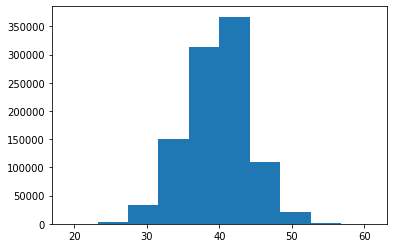

In [346]:
plt.hist(key_sizes) # 1000000

In [347]:
min(key_sizes)

19

In [348]:
max(key_sizes)

61

(array([1.8000e+01, 3.0000e+02, 3.3900e+03, 1.5210e+04, 2.2374e+04,
        3.3341e+04, 1.9394e+04, 5.2770e+03, 6.6400e+02, 3.2000e+01]),
 array([20. , 23.8, 27.6, 31.4, 35.2, 39. , 42.8, 46.6, 50.4, 54.2, 58. ]),
 <BarContainer object of 10 artists>)

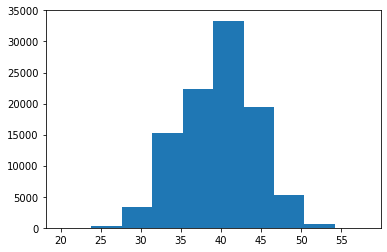

In [342]:
plt.hist(key_sizes) # 100000

(array([1.2000e+01, 3.1900e+02, 3.4660e+03, 1.5018e+04, 2.2540e+04,
        3.3349e+04, 1.9348e+04, 5.2510e+03, 6.6300e+02, 3.4000e+01]),
 array([20. , 23.8, 27.6, 31.4, 35.2, 39. , 42.8, 46.6, 50.4, 54.2, 58. ]),
 <BarContainer object of 10 artists>)

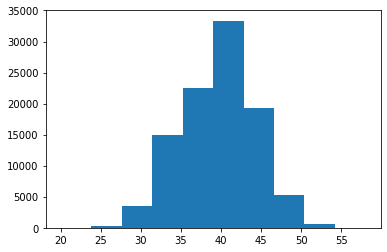

In [338]:
plt.hist(key_sizes) # 100000

(array([ 2.,  2.,  8.,  5., 19., 32., 11., 13.,  6.,  2.]),
 array([27. , 29.2, 31.4, 33.6, 35.8, 38. , 40.2, 42.4, 44.6, 46.8, 49. ]),
 <BarContainer object of 10 artists>)

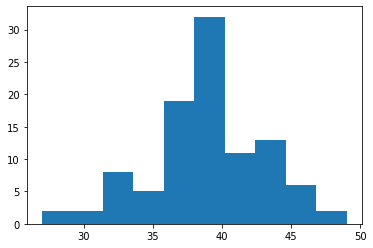

In [340]:
plt.hist(key_sizes) # 100

In [297]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived = split_flat_parts_at_mid(flat_parts, depth=0, max_depth=5)

In [293]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived = split_flat_parts_at_mid(flat_parts, depth=0, max_depth=1)

In [ ]:
[27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ##########################################
 ['DERIVE'],
 47,
 ################
 53,
 21,
 9]

In [294]:
flat_parts

[27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ['DERIVE'],
 47,
 53,
 21,
 9]

In [295]:
for_eval

['AND',
 27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ['DERIVE'],
 47,
 53,
 21,
 9]

In [267]:
for_eval[2]

['AND', ['AND', ['DERIVE'], 47], ['AND', 53, ['AND', 21, 9]]]

In [279]:
for_eval

['AND',
 ['AND',
  ['AND', 27, 40],
  ['AND', ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28], ['AND', 59, 13]]],
 ['AND', ['AND', ['DERIVE'], 47], ['AND', 53, ['AND', 21, 9]]]]

In [ ]:
[27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ['DERIVE'],
 47,
 53,
 21,
 9]

In [286]:
pos_part_to_be_derived

[1, 1, 2]

In [287]:
for_eval[2]

['AND', ['AND', ['DERIVE'], 47], ['AND', 53, ['AND', 21, 9]]]

In [ ]:
left_part = ['AND', ['AND', 27, 40]]
right_part = 

In [251]:
flat_parts2 = [52, ['DERIVE'], 80]

In [252]:
for_eval, for_input, depth, has_part_to_be_derived, pos_part_to_be_derived = split_flat_parts_at_mid(flat_parts2, depth=0, max_depth=5)

In [254]:
for_eval, depth

(['AND', 52, ['AND', ['DERIVE_OR'], 80]], 2)

In [250]:
for_eval[1][1][2]

['DERIVE_OR']

In [245]:
''.join([str(i) for i in for_input])

"(((52&['DERIVE_OR'])&((2|4|5|6|11|15|23|25|28|29|34|38|40|44|49|57|63|66|76|80)&(24&31)))&((31&29)&(22&(48&76))))"

In [ ]:
(((52&['DERIVE'])&((2|4|5|6|11|15|23|25|28|29|34|38|40|44|49|57|63|66|76|80)&(24&31)))&((31&29)&(22&(48&76))))

In [261]:
flat_parts = [27,
 40,
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
 59,
 13,
 ['DERIVE'],
 47,
 53,
 21,
 9]

In [136]:
flat_parts = [27,
 40,
#######
 ['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28],
###
 59,
 13,
###############
 ['DERIVE'],
 47,
#######
 53,
###
 21,
 9]

In [262]:
exp = ['AND',
  ['AND',
       ['AND', 27, 40],
       ['AND', [['OR', 32, 2, 46, 79, 80, 54, 26, 27, 28]], ['AND', 59, 13]]
  ],
  ['AND', 
       ['AND', ['DERIVE'], 47], 
       ['AND', [53], ['AND', 21, 9]]
  ]
]

exp[2][1][1]

['DERIVE']

In [ ]:
# 1. SET
# 2. SET Shatter
# 3. SET Nested
# 4. SET Shatter and Nested

In [ ]:
# Sample a query with required length that returns the answer.
# 
# 

In [126]:
['('] + list(reversed([1,2,3])) + [')']

['(', 3, 2, 1, ')']

In [ ]:
# check if num_cards in slots are even

In [41]:
def make_query(num_attributes, num_attr_vals, num_AND, num_OR, nest_depth):

    num_cards = num_attr_vals ** num_attributes
    query = list(np.random.choice(num_cards, size=num_AND+1))
    
    
    
    
    return query


array([79, 22, 71, 69, 51, 49,  6, 15, 68, 65, 60])

In [ ]:
# Default embed by property hparams, main

In [ ]:
# Use case

# sample query_datapoints (use idx)
# --> make vocab tokens

# 

In [45]:
list(range(1,5))

[1, 2, 3, 4]

In [ ]:
# draw num_AND card indices
# decode into key properties

# draw num_OR positions within range num_AND
# for each of these positions, draw a random set of cards, replace the position with ['OR', ...]

# run split in mid to return query part for eval and query part for input

In [ ]:
# inspect the format, run eval code on it and 

In [ ]:
# what are the new hyperparams?

# num attrs
# num attr vals

# ?
# num cards per query
# AND OR

# nest depth.


# how to evaluate?

# how to convert between indices?